In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
def prepare_gridded_data(predictions, raw_data, px_coords, time_index):
    print('Time Index: ', time_index)
    # Reshape predictions
    predictions_reshaped = predictions[:, time_index, 0]
    
    # Extract the corresponding time from raw_data
    raw_data_time = raw_data[-predictions.shape[1]:, :, 0][time_index]
    lst_data = raw_data[-predictions.shape[1]:, :, 1][time_index]
    precipitation_data = raw_data[-predictions.shape[1]:, :, 2][time_index]
    
    # Parse px_coords
    coords = np.array([eval(coord) for coord in px_coords])
    
    # Create a DataFrame
    df = pd.DataFrame({
        'longitude': coords[:, 0],
        'latitude': coords[:, 1],
        'predictions': predictions_reshaped,
        'raw_data': raw_data_time,
        'lst_data': lst_data,
        'prec_data': precipitation_data
    })
    
    # Find unique lat and lon values
    unique_lons = np.sort(df['longitude'].unique())
    unique_lats = np.sort(df['latitude'].unique())
    
    # Create 2D grids for the data
    lon_grid, lat_grid = np.meshgrid(unique_lons, unique_lats)
    
    # Create 2D grids for predictions and raw_data
    predictions_grid = np.full(lon_grid.shape, np.nan)
    raw_data_grid = np.full(lon_grid.shape, np.nan)
    lst_data_grid = np.full(lon_grid.shape, np.nan)
    prec_data_grid = np.full(lon_grid.shape, np.nan)
    
    for _, row in df.iterrows():
        i = np.where(unique_lats == row['latitude'])[0][0]
        j = np.where(unique_lons == row['longitude'])[0][0]
        predictions_grid[i, j] = row['predictions']
        raw_data_grid[i, j] = row['raw_data']
        lst_data_grid[i, j] = row['lst_data']
        prec_data_grid[i, j] = row['prec_data']
    
    return lon_grid, lat_grid, predictions_grid, raw_data_grid, lst_data_grid, prec_data_grid

In [4]:
pixel_coord_path = '/data/tapas/cnn_lstm/malawi/cnn_lstm_training/flattened_arrs/1D_coords.npy'
sweep_name = "elated-sweep-82"
predictions_path = f'/data/tapas/cnn_lstm/malawi/ml_production/{sweep_name}_full_predictions_tv2.npy'
raw_data_path = "/data/tapas/cnn_lstm/malawi/cnn_lstm_training/flattened_arrs/3D_nonstatic_v1.npy"

In [6]:
predictions = np.load(predictions_path)
raw_data = np.load(raw_data_path)
px_coords = np.load(pixel_coord_path, allow_pickle=True)

In [9]:
px_coords.shape, raw_data.shape, predictions.shape

((1003355,), (555, 1003355, 3), (1003355, 146, 1))

In [12]:
lon_grid, lat_grid, predictions_grid, \
    raw_data_grid, lst_data_grid, prec_data_grid = prepare_gridded_data(predictions, raw_data, px_coords, 0)

Time Index:  0


In [61]:
import rioxarray as rxr
import xarray as xr
import rasterio

In [59]:
from rasterio.transform import Affine
x = lon_grid[0]
y = lat_grid[:,0]
resx = (x[-1] - x[0]) / len(x)
resy = (y[-1] - y[0]) / len(y)

transform = Affine.translation(x[0] - resx / 2, y[0] - resy / 2) * Affine.scale(resx, resy)

transform

Affine(0.002090390446702313, 0.0, 32.673846536327105,
       0.0, 0.002080446712407104, -17.130828542195648)

In [67]:
new_dataset = rasterio.open(

    './new.tif',

    'w',

    driver='GTiff',

    height=predictions_grid.shape[0],

    width=predictions_grid.shape[1],

    count=1,

    dtype=predictions_grid.dtype,

    crs='+proj=latlong',

    transform=transform,

)
new_dataset.write(predictions_grid, 1)
new_dataset.close()

In [33]:
lon_grid[:,1]

array([32.67905374, 32.67905374, 32.67905374, ..., 32.67905374,
       32.67905374, 32.67905374])

In [45]:
pred_xr = xr.DataArray(predictions_grid, dims=("y", "x"), coords={"y": lat_grid[:,0], "x":lon_grid[0], "time_index":0})

In [46]:
pred_xr

<xarray.DataArray (y: 3731, x: 1552)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y           (y) float64 -17.13 -17.13 -17.13 -17.12 ... -9.372 -9.37 -9.368
  * x           (x) float64 32.67 32.68 32.68 32.68 ... 35.91 35.91 35.92 35.92
    time_index  int64 0

In [50]:
pred_xr.to_netcdf("temp_pred_out.nc")

In [68]:
pred_rxr = rxr.open_rasterio("./new.tif")

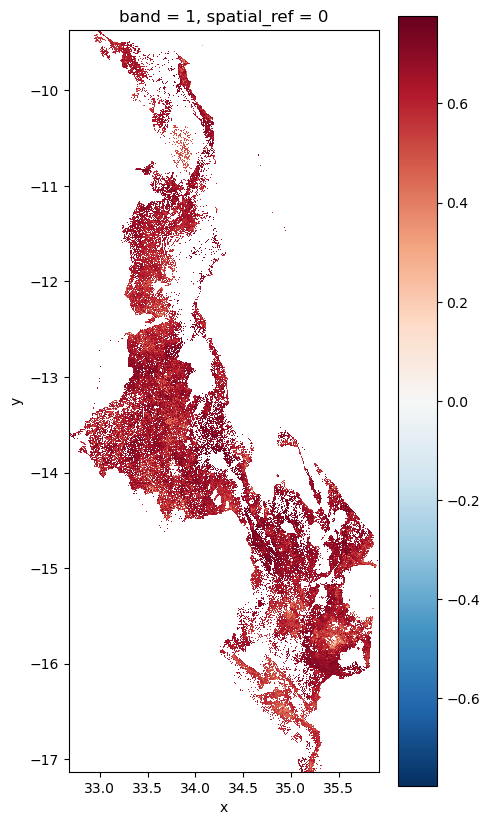

In [80]:
plt.figure(figsize=(5, 10))
pred_rxr.plot()
plt.gca().set_aspect('equal')

AttributeError: module 'rioxarray' has no attribute 'DataArray'